In [1]:
DATA_FILE ='../data/hazmat_incidents.csv'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
####################################################

import datetime as dt
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

####################################################
# everett@bayesimpact.org
####################################################

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Helpers (currently cut and paste around different notebooks... oops)

def percentify_axis(ax, which):
    which = which.lower()
    if which in ('x', 'both'):
        ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])
    if which in ('y', 'both'):
        ax.set_yticklabels(['%.0f%%' % (t*100) for t in ax.get_yticks()])

color_idx = 0
CYCLE_COLORS = sns.color_palette()
def next_color():
    global color_idx
    c = CYCLE_COLORS[color_idx] 
    color_idx = (color_idx + 1) % len(CYCLE_COLORS)
    return c

def count_unique(s):
    values = s.unique()
    return sum(1 for v in values if pd.notnull(v))

def missing_pct(s):
    missing = N - s.count()
    return missing * 100.0 / N

def complete_pct(s):
    return 100 - missing_pct(s)

def summarize_completeness_uniqueness(df):
    print '*** How complete is each feature? How many different values does it have? ***'
    rows = []
    for col in df.columns:
        rows.append([col, '%.0f%%' % complete_pct(df[col]), count_unique(df[col])])
    return pd.DataFrame(rows, columns=['Column Name', 'Complete (%)','Unique Values'])

def summarize_completeness_over_time(df, time_col, transpose=True):
    print '*** Data completeness over time per column ***'
    x = df.groupby(time_col).count()
    x = x.div(df.groupby(time_col).size(), axis=0)
    for col in x.columns:
        x[col] = x[col].apply(lambda value: '%.0f%%' % (value * 100))
    if transpose:
        return x.T
    return x

def plot_top_hist(df, col, top_n=10, skip_below=.01):
    '''Plot a histogram of a categorical dataframe column, limiting to the most popular.'''
    counts = df[col].value_counts(True, ascending=True)
    missing = missing_pct(df[col])
    if counts.max() < (skip_below / (1 - missing)):
        print 'Skipping "%s" histogram -- most common value is < %.0f%% of all cases' % (col, skip_below*100)
        return
    fig, ax = plt.subplots(1)
    explanation = ''
    if len(counts) > top_n:
        explanation = ' (top %d of %d)' % (top_n, len(counts))
        counts = counts.iloc[-top_n:]
    explanation += ' -- %.0f%% missing' % (missing)
    counts.plot(kind='barh', ax=ax, color=next_color())
    ax.set_title('Rows by "%s"%s' % (col, explanation))
    ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])


In [4]:
df = pd.read_csv(DATA_FILE)
print '%d rows %d columns' % df.shape
N = len(df)
df.head()

549343 rows 48 columns


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Report Submission Source,Multiple Rows per Incident,Report Number,Carrier/Reporter Name,Incident Route,Incident City,Incident State,Date of Incident,Time of Incident,Quantity Released,Unit of Measure,Identification Number,Commodity Long Name,Hazardous Class,Total Hazmat Fatalities,Total Hazmat Hosp Injuries,Total Hazmat NonHosp Injuries,Total Amount of Damages,Shipper Name,Origin City,Origin State,Mode of Transportation,Identification Markings,Cont1 Material of Construction,Cont1 Packaging Type,Cont1 Package Capacity,Cont1 Package Capacity UOM,Cont1 Pkg Number in Shipment,Cont1 Pkg Shipment Nbr Failed,Cont2 Material of Construction,Cont2 Package Type,Cont2 Package Capacity,Cont2 Capacity UOM Reported,Cont2 Pkg Number in Shipment,Cont2 Pkg Shipment Nbr Failed,What Failed Description,How Failed Description,Failure Cause Description,Description of Events,HMIS Serious Incident Ind,HMIS Serious Bulk Release,HMIS Serious Evacuations,HMIS Serious Fatality,HMIS Serious Flight Plan,HMIS Serious Injury,HMIS Serious Major Artery,HMIS Serious Marine Pollutant,HMIS Serious Radioactive
0,Paper,No,I-1992080463,ANAHUAC TRANSPORT INC.,I10 MI MARKER 785,HIGHLANDS,TX,07/09/1992,1545,385,LGA,UN1268,PETROLEUM DISTILLATE,COMBUSTIBLE LIQUID,0,0,0,7185,CHEVRON U.S.A. INC.,HOUSTON,TEXAS,Highway,NaN,NaN,NaN,9915.000000,LGA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,Basic Material,NaN,Defective Component or Device,LOADED TRAILER AT CHEVRON WITH HAD WEIGHT TRAI...,Yes,Yes,No,No,No,No,No,No,No
1,Paper,No,I-1973090124,COWAN W T INC,NaN,BALTIMORE,MD,09/06/1973,NaN,0,NaN,UN1987,ALCOHOLS N.O.S.,FLAMMABLE - COMBUSTIBLE LIQUID,0,0,0,0,PUBLICKER INC,PHILADELPHIA,PENNSYLVANIA,Highway,NaN,NaN,NaN,55.000000,LGA,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Corrosion - Exterior,NaN,No,No,No,No,No,No,No,No,No
2,Paper,No,I-1978120954,SOUTHEASTERN FREIGHT LINES INC,NaN,CONLEY,GA,12/14/1978,NaN,0,NaN,NA1760,COMPOUNDS CLEANING LIQUID,CORROSIVE MATERIAL,0,0,0,0,SENTRY CHEMICAL CO,STONE MOUNTAIN,GEORGIA,Highway,NaN,NaN,NaN,5.000000,LGA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Punctured,NaN,NaN,No,No,No,No,No,No,No,No,No
3,Paper,No,I-1993120650,MED-WASTE MANAGEMENT INC OF NEW ENGLAND,SR81MILE POST 102 8 REST AREA,PINE GROVE,PA,10/25/1993,1400,2,LGA,NA3082,HAZARDOUS WASTE LIQUID N.O.S.,MISCELLANEOUS HAZARDOUS MATERIAL,0,0,0,223,M. S. COMPANY,ATTLEBORO,MASSACHUSETTS,Highway,NaN,NaN,NaN,55.000000,LGA,92,1,NaN,NaN,NaN,NaN,NaN,NaN,Basic Material,NaN,NaN,DRIVER WAS PULLED OVER FOR A ROUTINE INSPECTIO...,No,No,No,No,No,No,No,No,No
4,Paper,No,I-2007100491,UNITED PARCEL SERVICE INC.,5101 TRABUE RD,COLUMBUS,OH,10/11/2007,1920,1,LGA,UN1263,PAINT INCLUDING PAINT LACQUER ENAMEL STAIN ...,FLAMMABLE - COMBUSTIBLE LIQUID,0,0,0,0,TUBELITE COMPANY INC,CHARLOTTE,NORTH CAROLINA,Highway,4G/Y14/S/07 USA/+AC2421,Reconsituted Wood,Box,3.698408,LGA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,Closure (e.g. Cap Top or Plug),Leaked,Inadequate Preparation for Transportation,NaN,No,No,No,No,No,No,No,No,No


In [ ]:
df['YEAR'] = df['Date of Incident'].apply(lambda d: int(d.split('/')[-1])).astype(int)

In [14]:
bad_times = 0
hours = []
minutes = []
for i, value in enumerate(df['Time of Incident']):
    if pd.isnull(value):
        hours.append(None)
        minutes.append(None)
        continue
    try:
        v = int(value)
        h = v / 100
        m = v % 100
        if h == 24:
            h = 0
        if h < 0 or h > 23 or m < 0 or m > 59:
            raise ValueError
        hours.append(h)
        minutes.append(m)
    except ValueError:
#         print i, value
        bad_times += 1
        hours.append(None)
        minutes.append(None)
        if printed > 50:
            break

print bad_times, 'times were invalid, converted them to None'
df['HOUR'] = hours
df['MINUTE'] = minutes

32 times were invalid, converted them to None


In [11]:
summarize_completeness_uniqueness(df)

*** How complete is each feature? How many different values does it have? ***


,Column Name,Complete (%),Unique Values
0,Report Submission Source,100%,3
1,Multiple Rows per Incident,100%,2
2,Report Number,100%,538466
3,Carrier/Reporter Name,100%,13987
4,Incident Route,68%,94757
5,Incident City,100%,17002
6,Incident State,100%,57
7,Date of Incident,100%,16456
8,Time of Incident,73%,2938
9,Quantity Released,100%,8067


In [12]:
summarize_completeness_over_time(df, 'YEAR', transpose=False)

*** Data completeness over time per column ***


,Report Submission Source,Multiple Rows per Incident,Report Number,Carrier/Reporter Name,Incident Route,Incident City,Incident State,Date of Incident,Time of Incident,Quantity Released,Unit of Measure,Identification Number,Commodity Long Name,Hazardous Class,Total Hazmat Fatalities,Total Hazmat Hosp Injuries,Total Hazmat NonHosp Injuries,Total Amount of Damages,Shipper Name,Origin City,Origin State,Mode of Transportation,Identification Markings,Cont1 Material of Construction,Cont1 Packaging Type,Cont1 Package Capacity,Cont1 Package Capacity UOM,Cont1 Pkg Number in Shipment,Cont1 Pkg Shipment Nbr Failed,Cont2 Material of Construction,Cont2 Package Type,Cont2 Package Capacity,Cont2 Capacity UOM Reported,Cont2 Pkg Number in Shipment,Cont2 Pkg Shipment Nbr Failed,What Failed Description,How Failed Description,Failure Cause Description,Description of Events,HMIS Serious Incident Ind,HMIS Serious Bulk Release,HMIS Serious Evacuations,HMIS Serious Fatality,HMIS Serious Flight Plan,HMIS Serious Injury,HMIS Serious Major Artery,HMIS Serious Marine Pollutant,HMIS Serious Radioactive,HOUR,MINUTE
YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1971,100%,100%,100%,100%,0%,100%,98%,100%,0%,100%,1%,97%,100%,100%,100%,100%,100%,100%,100%,97%,97%,100%,0%,0%,0%,64%,64%,77%,83%,0%,0%,10%,10%,12%,13%,21%,34%,30%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%
1972,100%,100%,100%,100%,0%,100%,99%,100%,1%,100%,1%,99%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,65%,65%,72%,74%,0%,0%,17%,17%,22%,23%,19%,31%,31%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,1%,1%
1973,100%,100%,100%,100%,0%,100%,99%,100%,0%,100%,0%,98%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,66%,66%,71%,72%,0%,0%,20%,20%,26%,27%,18%,32%,36%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%
1974,100%,100%,100%,100%,0%,100%,99%,100%,0%,100%,0%,98%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,59%,59%,67%,68%,0%,0%,22%,22%,29%,30%,19%,33%,40%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%
1975,100%,100%,100%,100%,0%,100%,100%,100%,0%,100%,4%,98%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,65%,65%,71%,71%,0%,0%,21%,21%,28%,28%,20%,32%,40%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%
1976,100%,100%,100%,100%,0%,100%,100%,100%,0%,100%,64%,99%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,85%,85%,96%,98%,0%,0%,18%,18%,22%,24%,22%,31%,59%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%
1977,100%,100%,100%,100%,0%,100%,100%,100%,2%,100%,66%,99%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,84%,84%,98%,98%,0%,0%,14%,14%,18%,19%,25%,30%,45%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,2%,2%
1978,100%,100%,100%,100%,0%,100%,99%,100%,0%,100%,72%,99%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,86%,86%,98%,99%,0%,0%,19%,19%,24%,25%,32%,40%,59%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%
1979,100%,100%,100%,100%,0%,100%,100%,100%,0%,100%,70%,99%,100%,100%,100%,100%,100%,100%,100%,99%,99%,100%,0%,0%,0%,86%,86%,99%,98%,0%,0%,20%,20%,27%,27%,31%,39%,62%,0%,100%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%


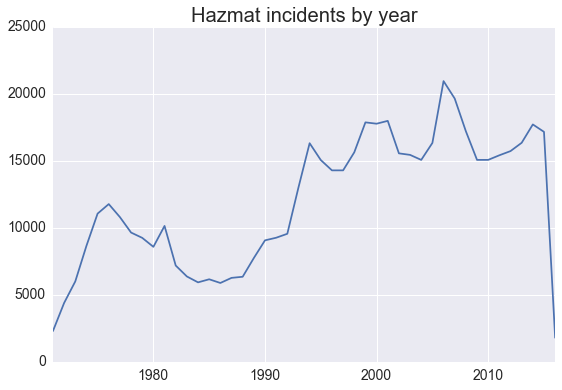

In [15]:
fig, ax = plt.subplots(1)
df['YEAR'].value_counts().sort_index().plot(ax=ax, label='All')
ax.set_title('Hazmat incidents by year')

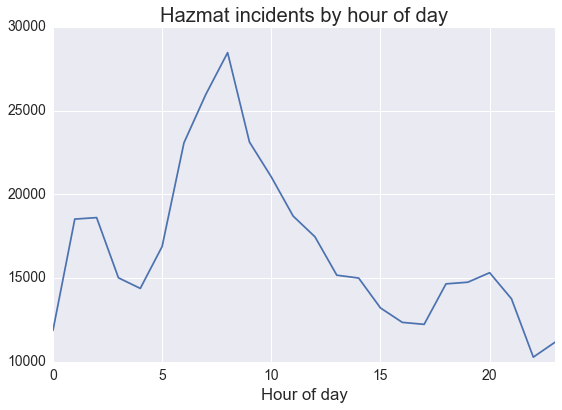

In [16]:
fig, ax = plt.subplots(1)
df['HOUR'].value_counts().sort_index().plot(ax=ax, label='All')
ax.set_title('Hazmat incidents by hour of day')
ax.set_xlabel('Hour of day')

### Summarize ALL the things!

Skipping "Report Number" histogram -- most common value is < 1% of all cases
Skipping "Date of Incident" histogram -- most common value is < 1% of all cases
Skipping "Shipper Name" histogram -- most common value is < 1% of all cases


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


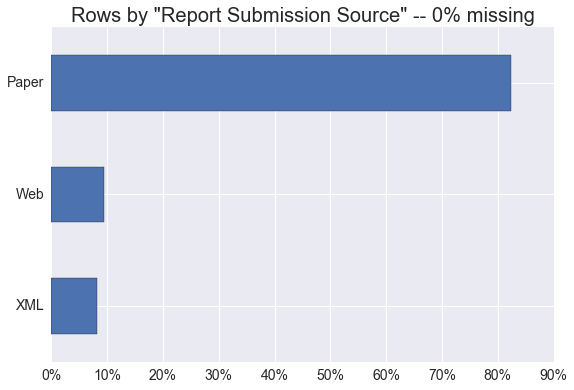

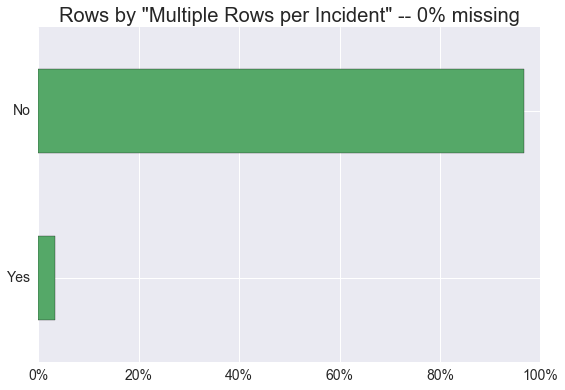

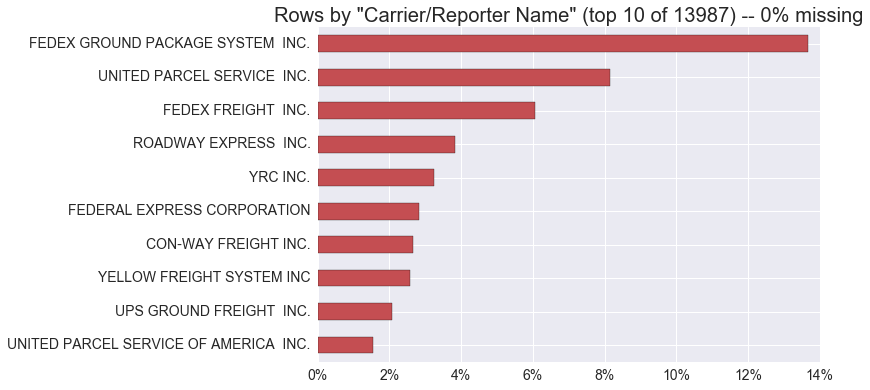

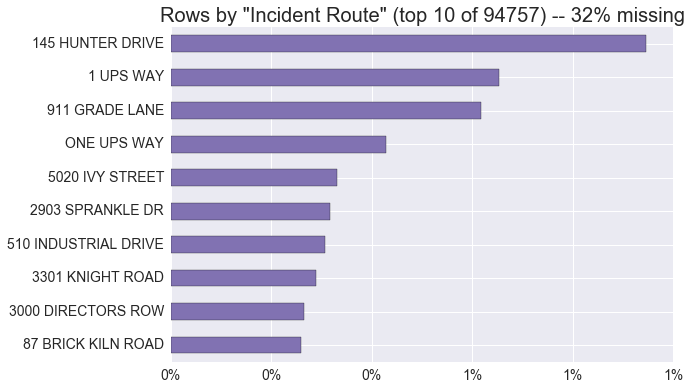

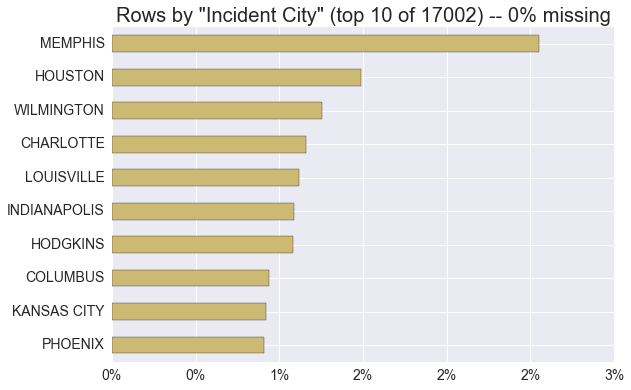

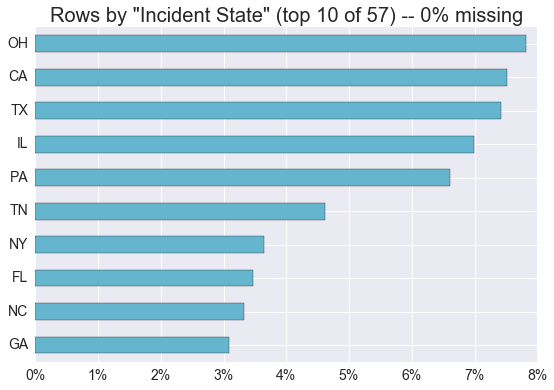

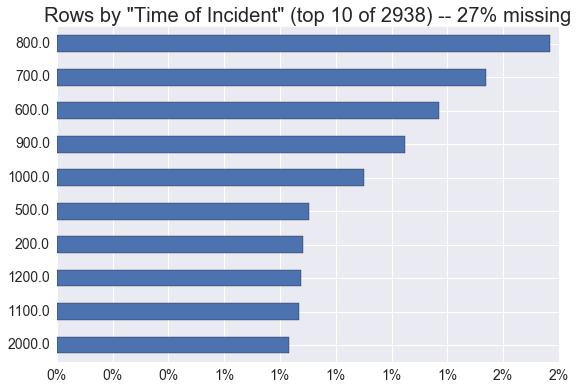

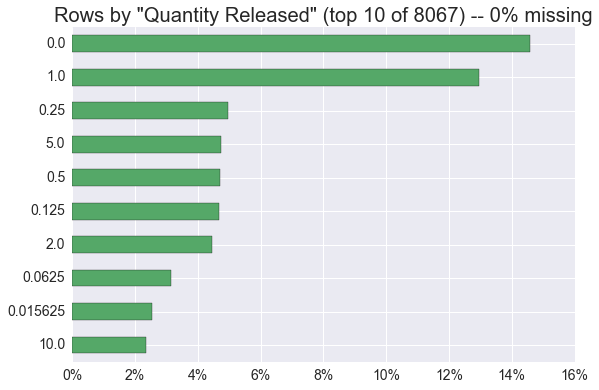

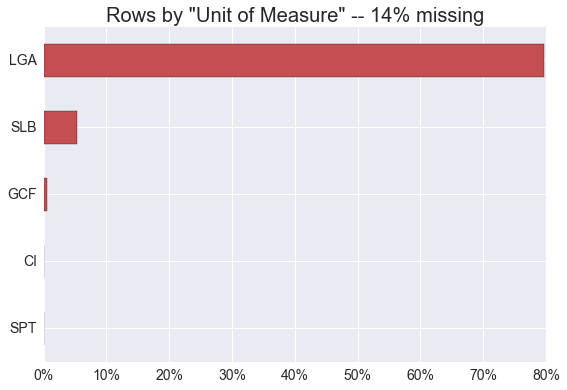

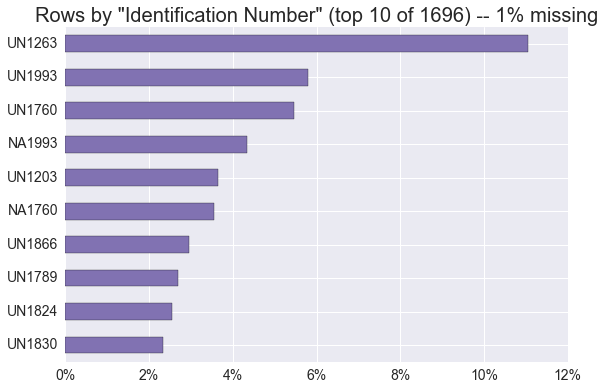

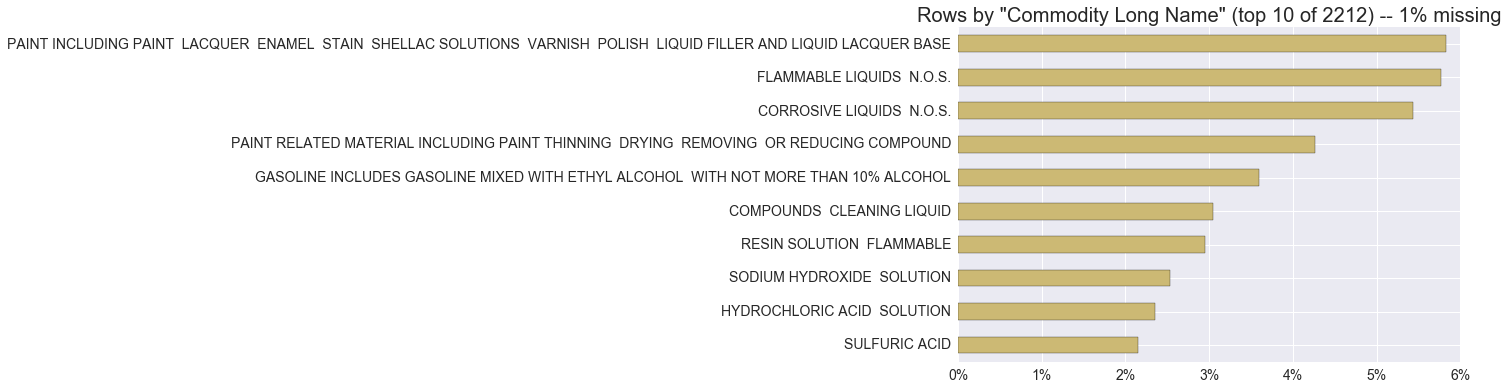

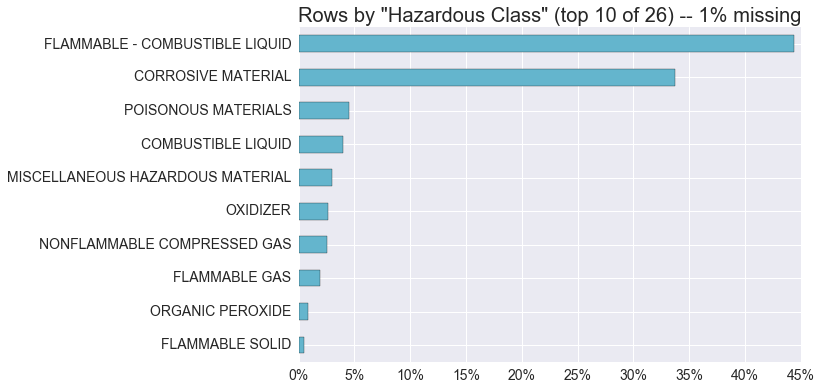

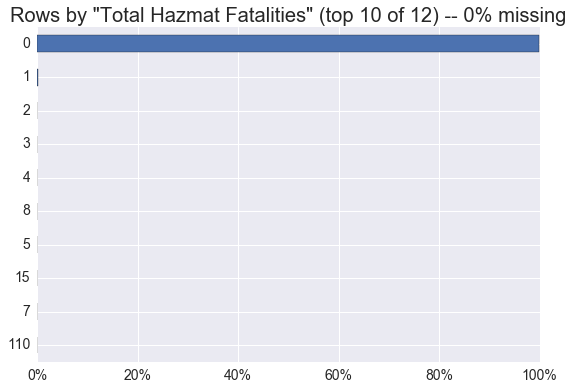

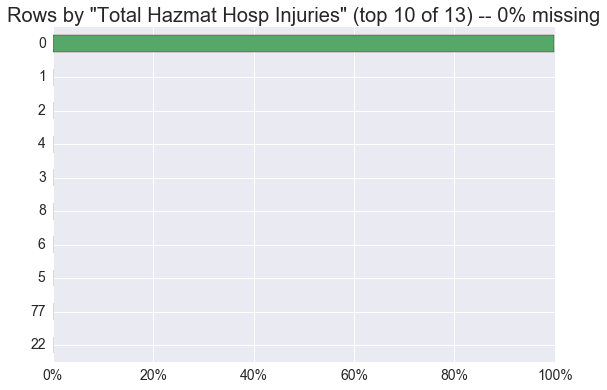

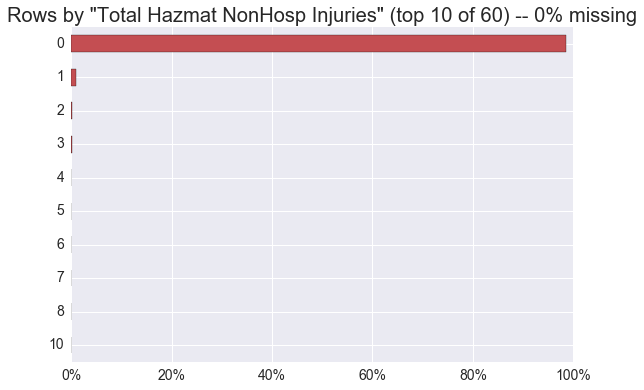

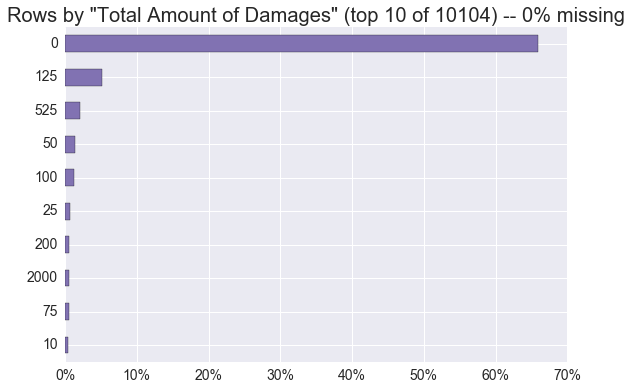

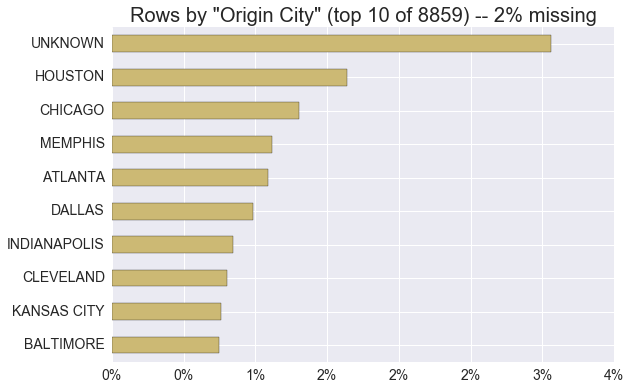

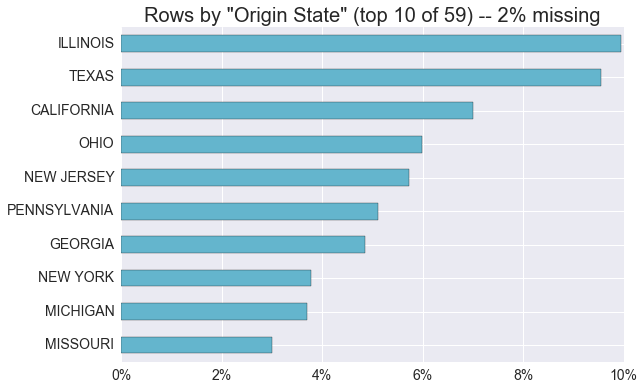

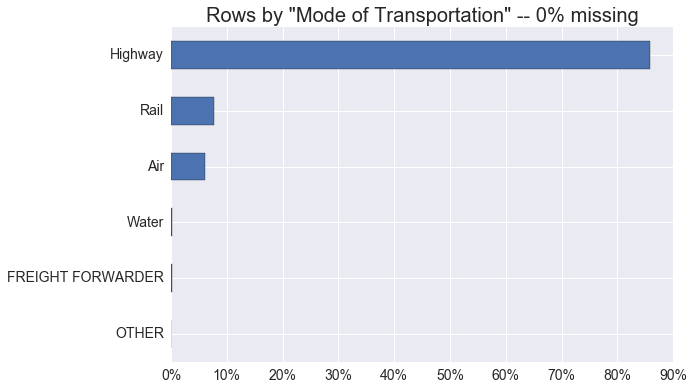

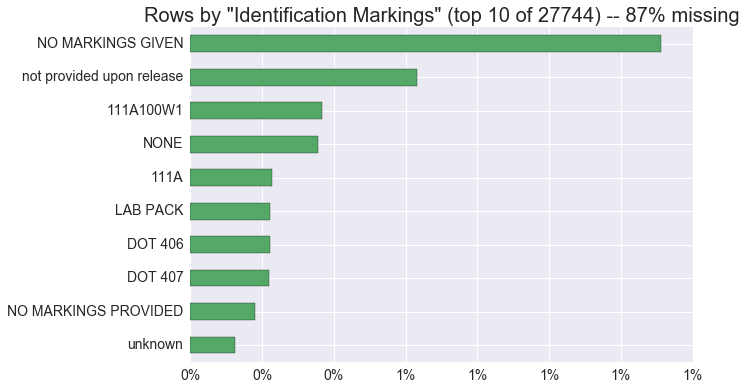

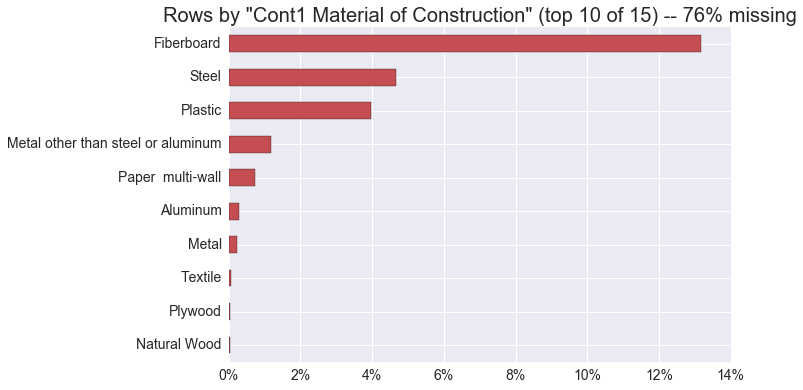

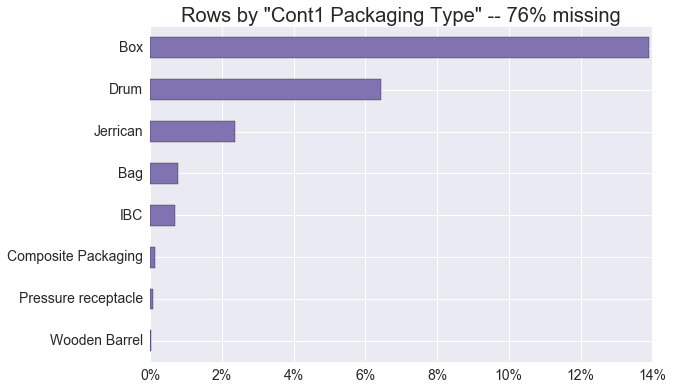

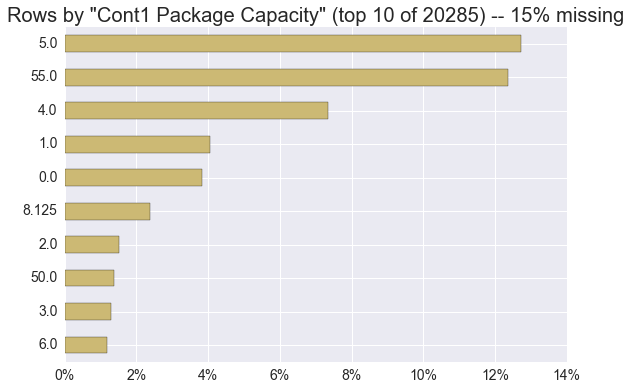

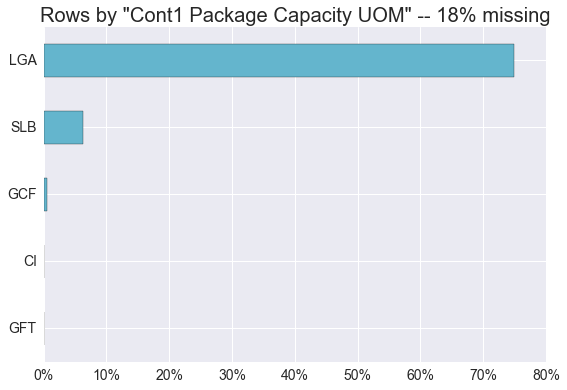

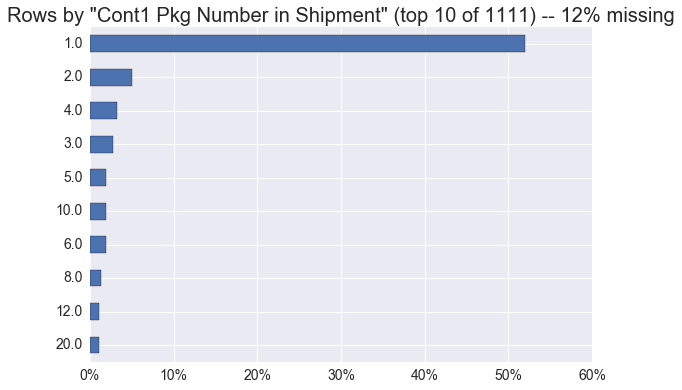

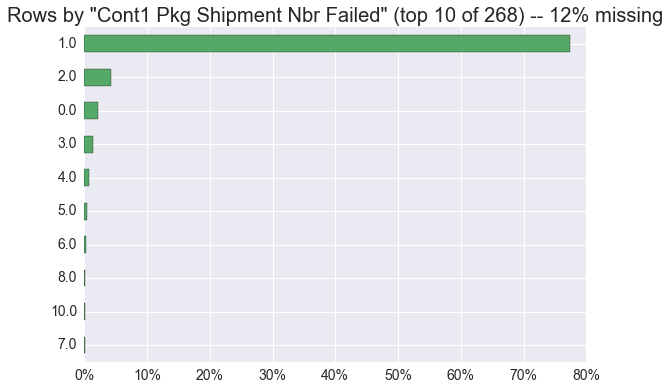

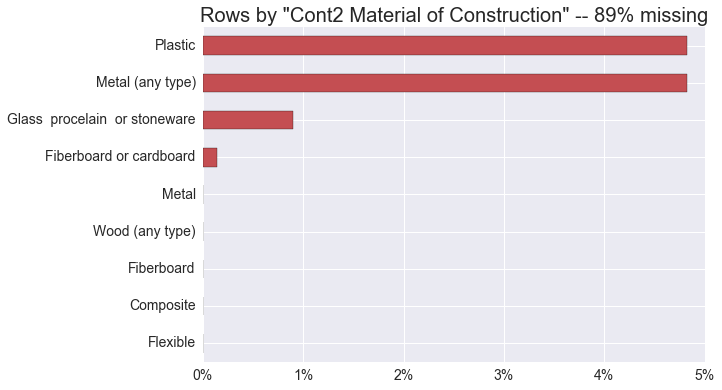

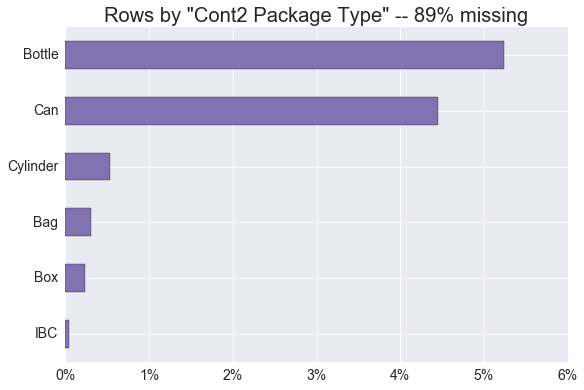

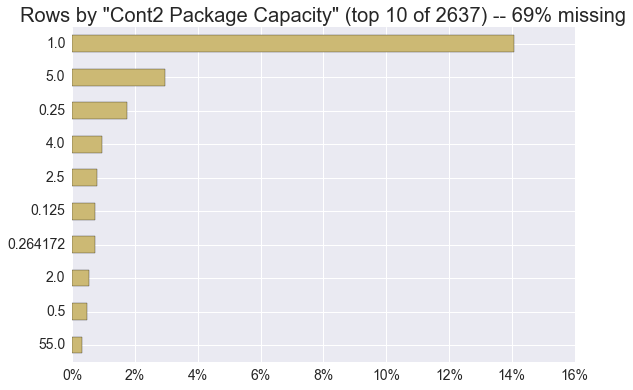

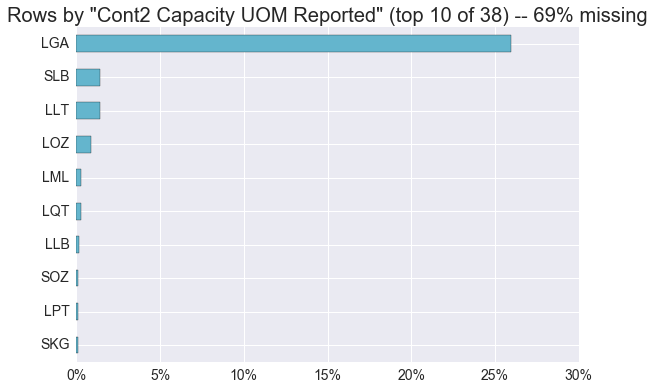

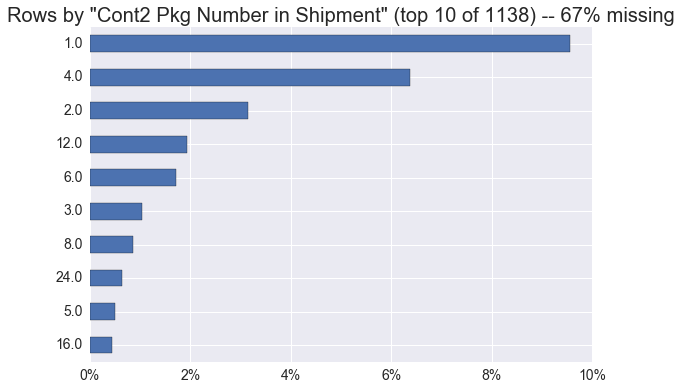

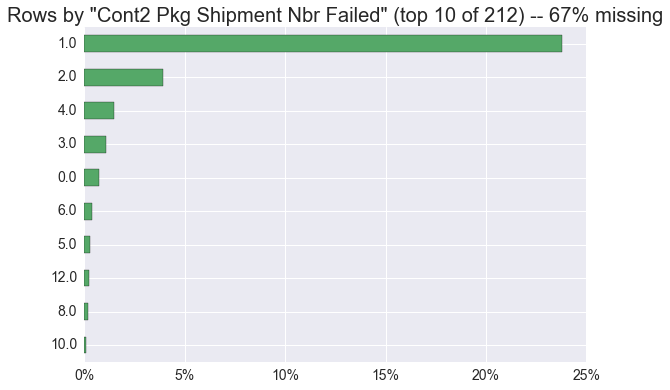

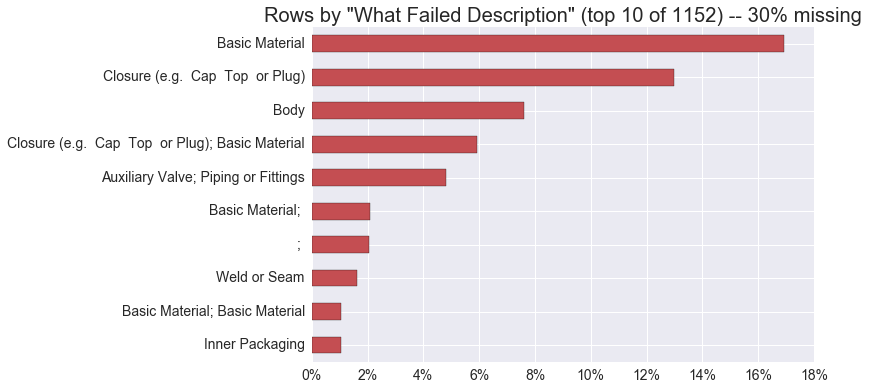

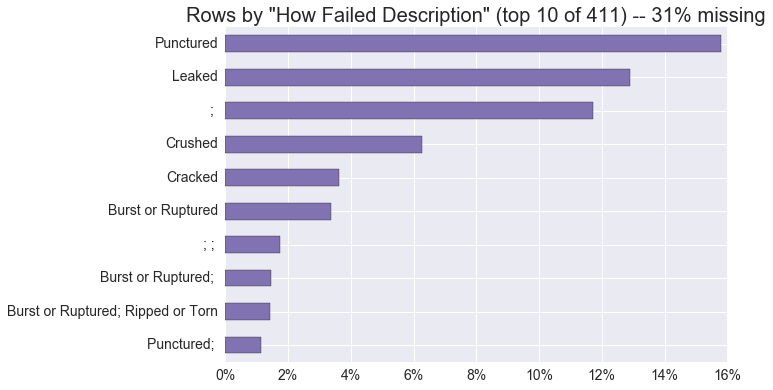

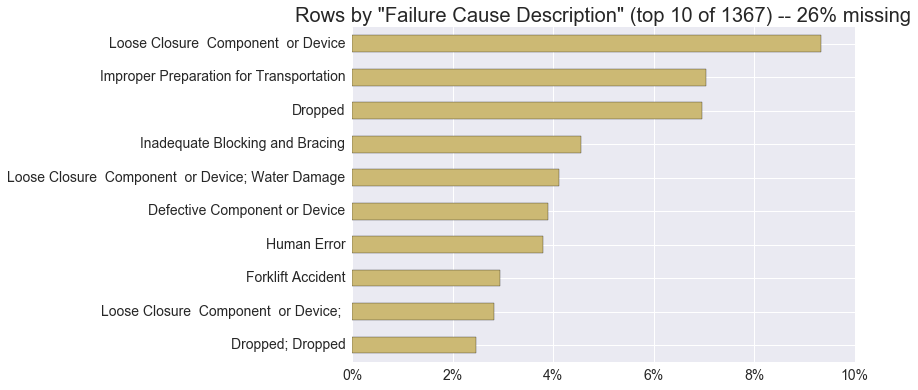

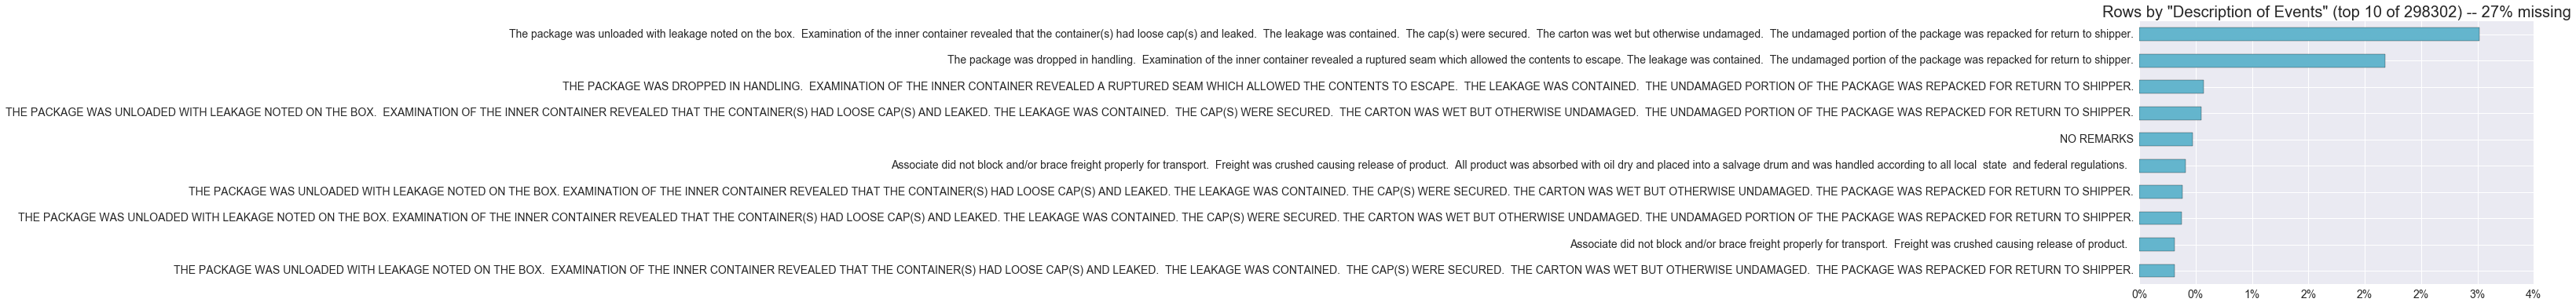

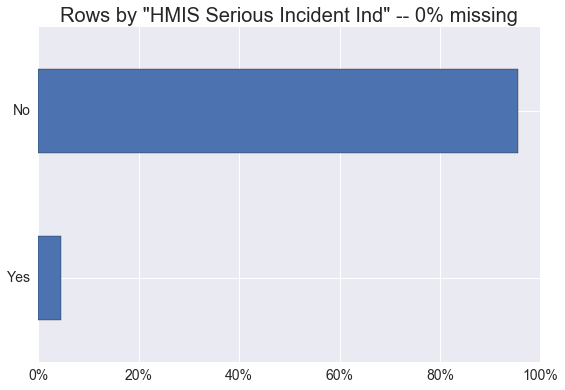

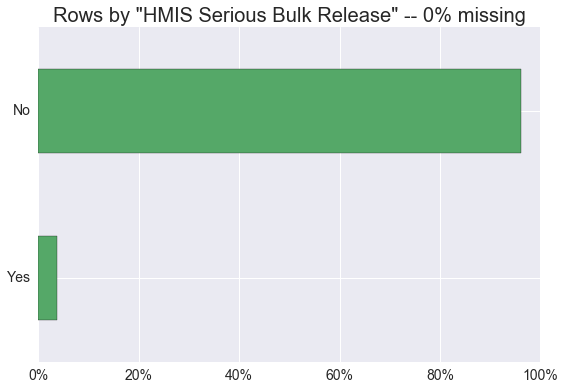

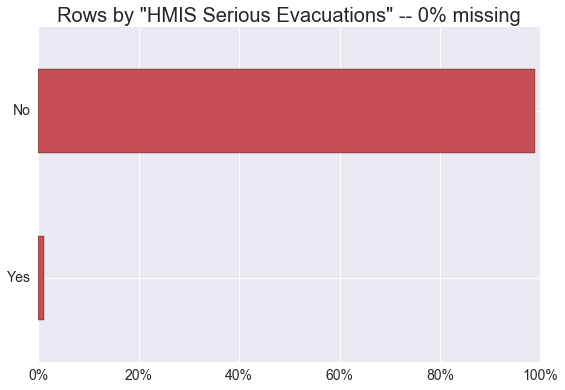

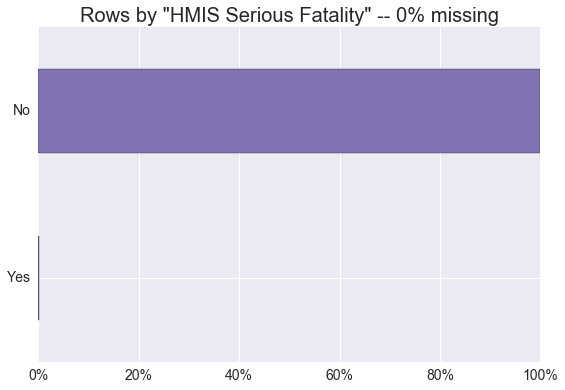

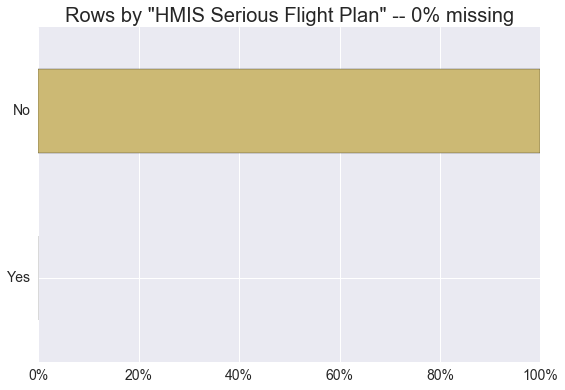

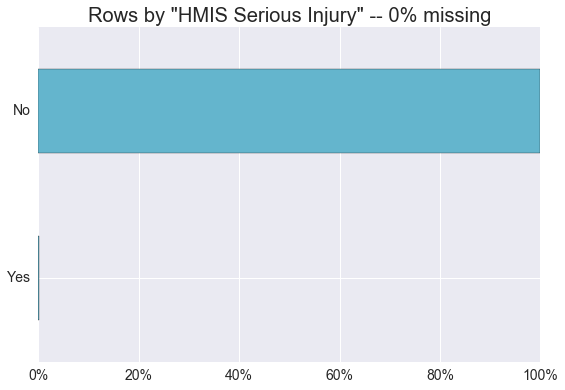

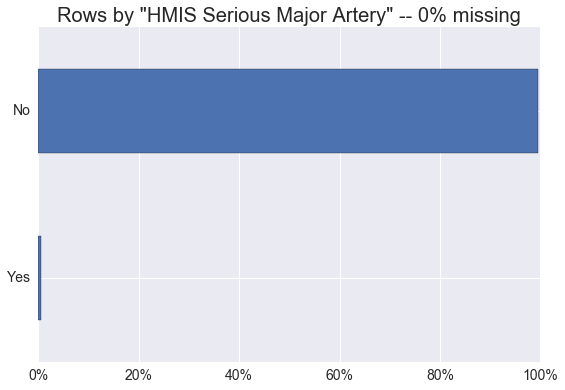

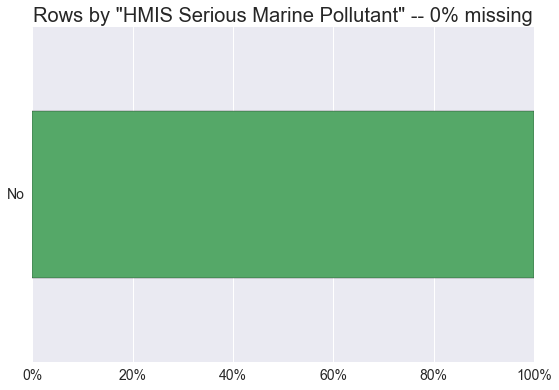

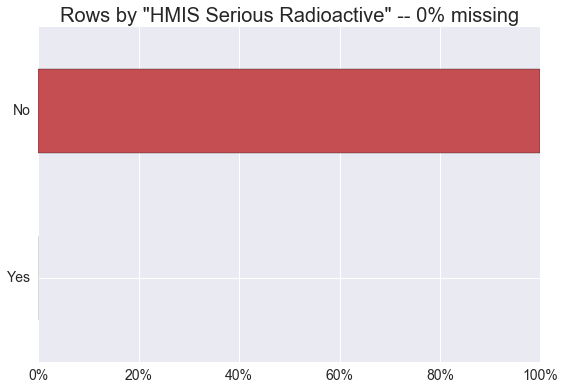

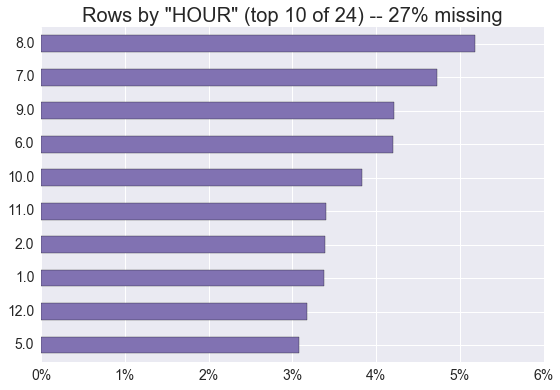

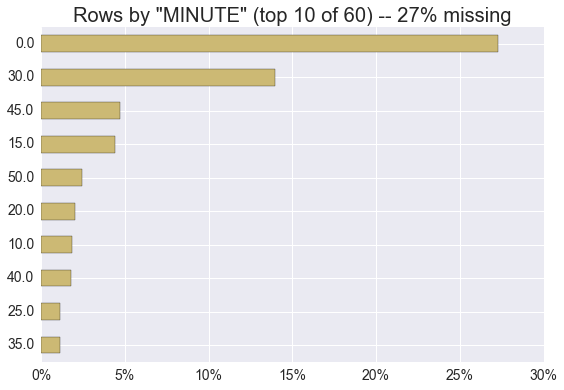

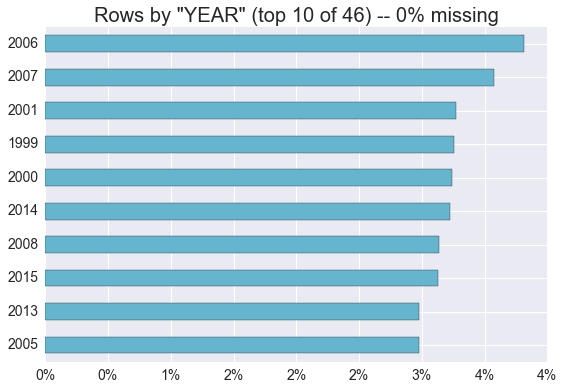

In [17]:
for col in df.columns:
    plot_top_hist(df, col)